In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

In [2]:
# ==========================================
# 1. DATA LOADING & PREPROCESSING
# ==========================================
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # Normalize to 0-1 and flatten for FC, keep shape for CNN
    x_train_flat = x_train.reshape(x_train.shape[0], -1) / 255.0
    x_test_flat = x_test.reshape(x_test.shape[0], -1) / 255.0
    x_train_cnn = x_train.reshape(-1, 28, 28) / 255.0

    # One-hot encode labels
    y_train_enc = np.eye(10)[y_train]
    y_test_enc = np.eye(10)[y_test]

    return (x_train_flat, y_train_enc), (x_test_flat, y_test_enc), x_train_cnn

load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


((array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  array([[0., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 1., 0.]])),
 (array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  array([[0., 0., 0., ..., 1., 0., 0.],
         [0., 0., 1., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0.,

In [3]:
# ==========================================
# 2. OPTIMIZERS (Strategy Pattern)
# ==========================================
class Optimizer:
    def __init__(self, lr=0.01): self.lr = lr
    def update(self, w, b, dw, db): pass

class SGD(Optimizer): # Handles Batch, Mini-batch, and SGDA based on usage
    def update(self, w, b, dw, db):
        w -= self.lr * dw
        b -= self.lr * db
        return w, b

class AdaGrad(Optimizer):
    def __init__(self, lr=0.01, epsilon=1e-8):
        super().__init__(lr)
        self.epsilon = epsilon
        self.cache_w = 0
        self.cache_b = 0
    def update(self, w, b, dw, db):
        self.cache_w += dw**2
        self.cache_b += db**2
        w -= self.lr * dw / (np.sqrt(self.cache_w) + self.epsilon)
        b -= self.lr * db / (np.sqrt(self.cache_b) + self.epsilon)
        return w, b

class RMSProp(Optimizer):
    def __init__(self, lr=0.001, decay=0.9, epsilon=1e-8):
        super().__init__(lr)
        self.decay, self.epsilon = decay, epsilon
        self.cache_w, self.cache_b = 0, 0
    def update(self, w, b, dw, db):
        self.cache_w = self.decay * self.cache_w + (1 - self.decay) * dw**2
        self.cache_b = self.decay * self.cache_b + (1 - self.decay) * db**2
        w -= self.lr * dw / (np.sqrt(self.cache_w) + self.epsilon)
        b -= self.lr * db / (np.sqrt(self.cache_b) + self.epsilon)
        return w, b

class Adam(Optimizer):
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(lr)
        self.beta1, self.beta2, self.epsilon = beta1, beta2, epsilon
        self.m_w, self.v_w, self.m_b, self.v_b = 0, 0, 0, 0
        self.t = 0
    def update(self, w, b, dw, db):
        self.t += 1
        # Weights
        self.m_w = self.beta1 * self.m_w + (1 - self.beta1) * dw
        self.v_w = self.beta2 * self.v_w + (1 - self.beta2) * (dw**2)
        m_hat_w = self.m_w / (1 - self.beta1**self.t)
        v_hat_w = self.v_w / (1 - self.beta2**self.t)
        w -= self.lr * m_hat_w / (np.sqrt(v_hat_w) + self.epsilon)
        # Biases
        self.m_b = self.beta1 * self.m_b + (1 - self.beta1) * db
        self.v_b = self.beta2 * self.v_b + (1 - self.beta2) * (db**2)
        m_hat_b = self.m_b / (1 - self.beta1**self.t)
        v_hat_b = self.v_b / (1 - self.beta2**self.t)
        b -= self.lr * m_hat_b / (np.sqrt(v_hat_b) + self.epsilon)
        return w, b



In [10]:
class FullyConnectedNN:
    def __init__(self, input_size, hidden_size, output_size, optimizer_class, optimizer_kwargs=None):
        # Xavier Initialization
        self.w1 = np.random.randn(input_size, hidden_size) * np.sqrt(1./input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.w2 = np.random.randn(hidden_size, output_size) * np.sqrt(1./hidden_size)
        self.b2 = np.zeros((1, output_size))

        if optimizer_kwargs is None:
            optimizer_kwargs = {}

        # Instantiate separate optimizers for each layer's parameters
        self.opt1 = optimizer_class(**optimizer_kwargs) # Create a new instance for layer 1
        self.opt2 = optimizer_class(**optimizer_kwargs) # Create a new instance for layer 2

    def sigmoid(self, z): return 1 / (1 + np.exp(-z))

    def forward(self, X):
        self.z1 = np.dot(X, self.w1) + self.b1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.w2) + self.b2
        self.a2 = self.sigmoid(self.z2)
        return self.a2

    def train(self, X, y, batch_size=32, epochs=5): # Removed 'optimizer' argument
        loss_history = []
        for i in range(epochs):
            # Mini-batch logic
            permutation = np.random.permutation(X.shape[0])
            X_shuffled, y_shuffled = X[permutation], y[permutation]

            for j in range(0, X.shape[0], batch_size):
                xb = X_shuffled[j:j+batch_size]
                yb = y_shuffled[j:j+batch_size]

                # Forward
                y_pred = self.forward(xb)

                # Backprop (MSE Loss derivative * Sigmoid derivative)
                # dL/dy_pred = y_pred - yb
                delta2 = (y_pred - yb) * (y_pred * (1 - y_pred)) # Output error
                dw2 = np.dot(self.a1.T, delta2)
                db2 = np.sum(delta2, axis=0, keepdims=True)

                delta1 = np.dot(delta2, self.w2.T) * (self.a1 * (1 - self.a1)) # Hidden error
                dw1 = np.dot(xb.T, delta1)
                db1 = np.sum(delta1, axis=0, keepdims=True)

                # Optimization Step
                self.w1, self.b1 = self.opt1.update(self.w1, self.b1, dw1, db1)
                self.w2, self.b2 = self.opt2.update(self.w2, self.b2, dw2, db2)

            loss = np.mean((self.forward(X) - y)**2)
            loss_history.append(loss)
            print(f"Epoch {i+1}/{epochs}, Loss: {loss:.4f}")
        return loss_history

In [4]:
# ==========================================
# 4. CNN IMPLEMENTATION (Forward Pass)
# ==========================================
class SimpleCNN:
    def __init__(self):
        # 3x3 filters. Simple fixed random weights for demo.
        self.f1 = np.random.randn(8, 3, 3) * 0.1 # 8 filters
        self.f2 = np.random.randn(16, 3, 3) * 0.1 # 16 filters
        self.fc_w = np.random.randn(16 * 4 * 4, 10) * 0.1 # 4x4 comes from 28->26->13->11->5 (approx)

    def conv2d(self, img, filters):
        h, w = img.shape
        num_f, f_h, f_w = filters.shape
        out_h, out_w = h - f_h + 1, w - f_w + 1
        output = np.zeros((num_f, out_h, out_w))
        for f in range(num_f):
            for i in range(out_h):
                for j in range(out_w):
                    output[f, i, j] = np.sum(img[i:i+f_h, j:j+f_w] * filters[f])
        return output

    def relu(self, x): return np.maximum(0, x)

    def maxpool(self, x):
        c, h, w = x.shape
        new_h, new_w = h // 2, w // 2
        out = np.zeros((c, new_h, new_w))
        for i in range(new_h):
            for j in range(new_w):
                out[:, i, j] = np.max(x[:, 2*i:2*i+2, 2*j:2*j+2], axis=(1, 2))
        return out

    def forward(self, img):
        # Conv -> ReLU -> MaxPool -> Conv -> ReLU -> MaxPool -> FC
        x = self.conv2d(img, self.f1)
        x = self.relu(x)
        x = self.maxpool(x) # 28->26->13

        # Simplified second conv (treating channels simply for minimalism)
        # Real CNNs sum over input channels; here we process 1st channel of prev output for brevity
        x = self.conv2d(x[0], self.f2)
        x = self.relu(x)
        x = self.maxpool(x) # 13->11->5

        flat = x.flatten()
        # Resize if dims mismatch due to padding logic (safety for demo)
        if flat.shape[0] != self.fc_w.shape[0]:
            flat = flat[:self.fc_w.shape[0]]

        out = np.dot(flat, self.fc_w)
        return out



Testing


--- Comparing Optimizers on FC Neural Network ---

Training with Mini-Batch SGD...
Epoch 1/100, Loss: 0.1000
Epoch 2/100, Loss: 0.1000
Epoch 3/100, Loss: 0.1000
Epoch 4/100, Loss: 0.1000
Epoch 5/100, Loss: 0.1000
Epoch 6/100, Loss: 0.1000
Epoch 7/100, Loss: 0.0999
Epoch 8/100, Loss: 0.0999
Epoch 9/100, Loss: 0.0998
Epoch 10/100, Loss: 0.0974
Epoch 11/100, Loss: 0.0921
Epoch 12/100, Loss: 0.0904
Epoch 13/100, Loss: 0.0899
Epoch 14/100, Loss: 0.0895
Epoch 15/100, Loss: 0.0891
Epoch 16/100, Loss: 0.0859
Epoch 17/100, Loss: 0.0892
Epoch 18/100, Loss: 0.0890
Epoch 19/100, Loss: 0.0881
Epoch 20/100, Loss: 0.0869
Epoch 21/100, Loss: 0.0782
Epoch 22/100, Loss: 0.0744
Epoch 23/100, Loss: 0.0785
Epoch 24/100, Loss: 0.0749
Epoch 25/100, Loss: 0.0682
Epoch 26/100, Loss: 0.0706
Epoch 27/100, Loss: 0.0663
Epoch 28/100, Loss: 0.0654
Epoch 29/100, Loss: 0.0648
Epoch 30/100, Loss: 0.0643
Epoch 31/100, Loss: 0.0666
Epoch 32/100, Loss: 0.0638
Epoch 33/100, Loss: 0.0635
Epoch 34/100, Loss: 0.0632
Epoch 35

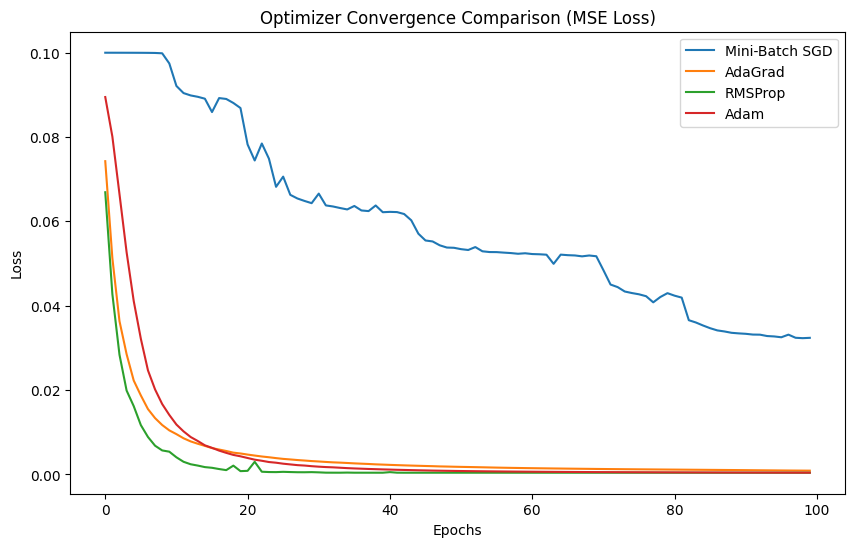

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

In [14]:
(X_train, Y_train), (X_test, Y_test), X_train_cnn = load_data()
subset = 1000 # Use subset for speed in Colab demo

print("--- Comparing Optimizers on FC Neural Network ---")
optimizers = {
    "Mini-Batch SGD": (SGD, {"lr": 0.1}),
    "AdaGrad": (AdaGrad, {"lr": 0.1}),
    "RMSProp": (RMSProp, {"lr": 0.01}),
    "Adam": (Adam, {"lr": 0.01})
}

plt.figure(figsize=(10, 6))
for name, (optimizer_class, kwargs) in optimizers.items():
    print(f"\nTraining with {name}...")
    nn = FullyConnectedNN(784, 64, 10, optimizer_class, kwargs)
    # Batch GDA: batch_size = len(X), SGDA: batch_size = 1. Using 64 for Mini-batch/Optimizers
    losses = nn.train(X_train[:subset], Y_train[:subset], batch_size=64, epochs=100)
    plt.plot(losses, label=name)

# These plt calls now apply to the figure where plots were drawn
plt.title("Optimizer Convergence Comparison (MSE Loss)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# make small plt (this is now a new, independent figure)
plt.figure(figsize=(6, 4))

In [8]:

print("\n--- Testing CNN Forward Pass (Architecture Demo) ---")
cnn = SimpleCNN()
sample_image = X_train_cnn[0]
output = cnn.forward(sample_image)
print(f"CNN Input Shape: {sample_image.shape}")
print(f"CNN Output Class Scores: {output}")
print("CNN Forward pass successful.")


--- Testing CNN Forward Pass (Architecture Demo) ---
CNN Input Shape: (28, 28)
CNN Output Class Scores: [ 0.07424917 -0.03235748  0.02835982 -0.06650809  0.11486754 -0.04339922
 -0.05796922  0.01084797 -0.08964821  0.01580745]
CNN Forward pass successful.


In [18]:
# using tensorflow cus else it was taking a lot of time
import tensorflow as tf

In [19]:
# 1. Load & Preprocess Data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [20]:


# Normalize and Reshape (28x28 grayscale -> (28, 28, 1))
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# (Conv -> ReLU -> MaxPool -> Conv -> ReLU -> MaxPool -> FC)
model = tf.keras.Sequential([
    # Layer 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Layer 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Fully Connected (FC)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:

# 3. Compile & Train
# Using Adam as the optimizer for best performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("Starting CNN Training...")
history = model.fit(x_train, y_train, epochs=30, batch_size=64, validation_split=0.1, verbose=1)


Starting CNN Training...
Epoch 1/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 50s 58ms/step - accuracy: 0.9804 - loss: 0.0619 - val_accuracy: 0.9880 - val_loss: 0.0406
Epoch 2/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 79s 54ms/step - accuracy: 0.9886 - loss: 0.0375 - val_accuracy: 0.9878 - val_loss: 0.0407
Epoch 3/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 45s 53ms/step - accuracy: 0.9920 - loss: 0.0251 - val_accuracy: 0.9900 - val_loss: 0.0346
Epoch 4/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 46s 55ms/step - accuracy: 0.9941 - loss: 0.0183 - val_accuracy: 0.9885 - val_loss: 0.0402
Epoch 5/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 45s 53ms/step - accuracy: 0.9954 - loss: 0.0132 - val_accuracy: 0.9913 - val_loss: 0.0344
Epoch 6/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 46s 54ms/step - accuracy: 0.9967 - loss: 0.0100 - val_accuracy: 0.9892 - val_loss: 0.0464
Epoch 7/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 44s 53ms/step - accuracy: 0.9964 - loss: 0.0104 - val_accuracy: 0.9898 - val_loss: 0.0445
Epoch 8/30
844/844 ━━━━━━━━━━━━━━━━━━━━ 46s 54ms/step - accuracy:


Test Accuracy: 99.23%
Test Loss: 0.0396


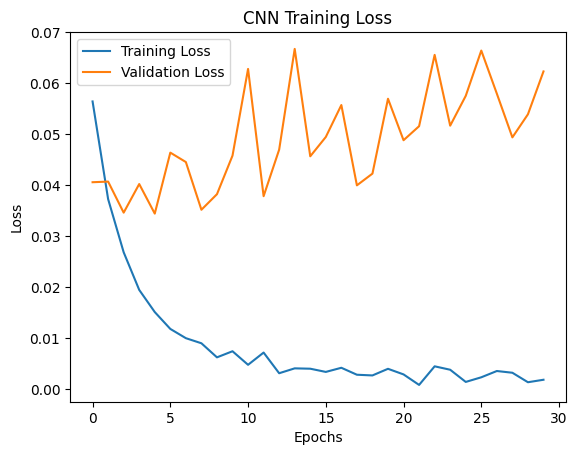

In [23]:

# 4. Evaluation
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# 5. Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()